## Data Wrangling and Cleaning

In [81]:
import pandas as pd
import numpy as np
import glob

folder_path = "/Users/adriamulero/opt/anaconda3/DATASCIENCE_PROJECTS/MBTI_audio_features"
csv_files = glob.glob(f"{folder_path}/*.csv")


# Getting the default mbti type data column names
column_names = ['mbti', 'danceability_mean', 'energy_mean','loudness_mean', 'mode_mean', 'speechiness_mean',
    'acousticness_mean', 'liveness_mean', 'valence_mean', 'tempo_mean', 'instrumentalness_mean']

# Initialize dictionaries to store data for each MBTI type
types_data = {"E": [], "I": [], "N": [], "S": [], "F": [], "T": [], "P": [], "J": []}

for file in csv_files:
    if file.endswith(".csv"):
        with open(file, "r") as f:
            first_line = f.readline()
            if ";" in first_line:
                delimiter = ";"
            else:
                delimiter = ","
        type_data = pd.read_csv(file, delimiter=delimiter)
        mbti_type = str(type_data["mbti"].iloc[0])
        mbti_df = type_data[column_names]
        
        # Storing each cognitive function
        f_1, f_2, f_3, f_4 = mbti_type[0], mbti_type[1], mbti_type[2], mbti_type[3]

        # Adding to its cognitive function DataFrames
        if f_1 == "E":
            types_data["E"].append(mbti_df)
        else:
            types_data["I"].append(mbti_df)
        if f_2 == "N":
            types_data["N"].append(mbti_df)
        else:
            types_data["S"].append(mbti_df)
        if f_3 == "F":
            types_data["F"].append(mbti_df)
        else:
            types_data["T"].append(mbti_df)
        if f_4 == "P":
            types_data["P"].append(mbti_df)
        else:
            types_data["J"].append(mbti_df)   

# Setting up final DataFrames before analysis
for function, data_list in types_data.items():
    if data_list:
        types_data[function] = pd.concat(data_list, ignore_index=True)

## Analysis

In [82]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import os
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats import levene

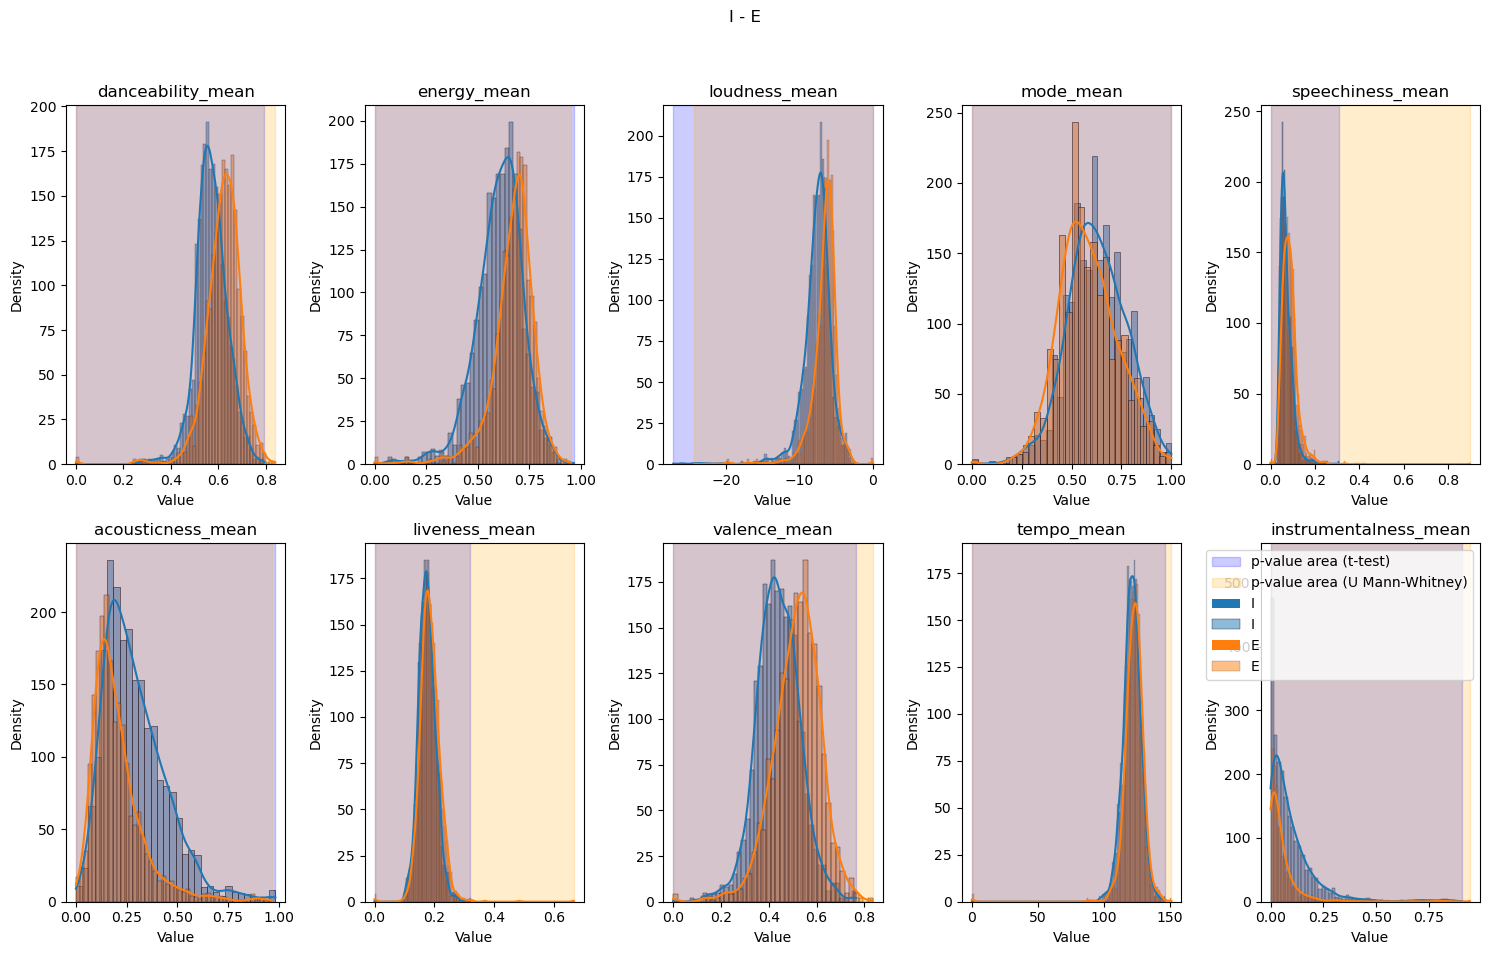

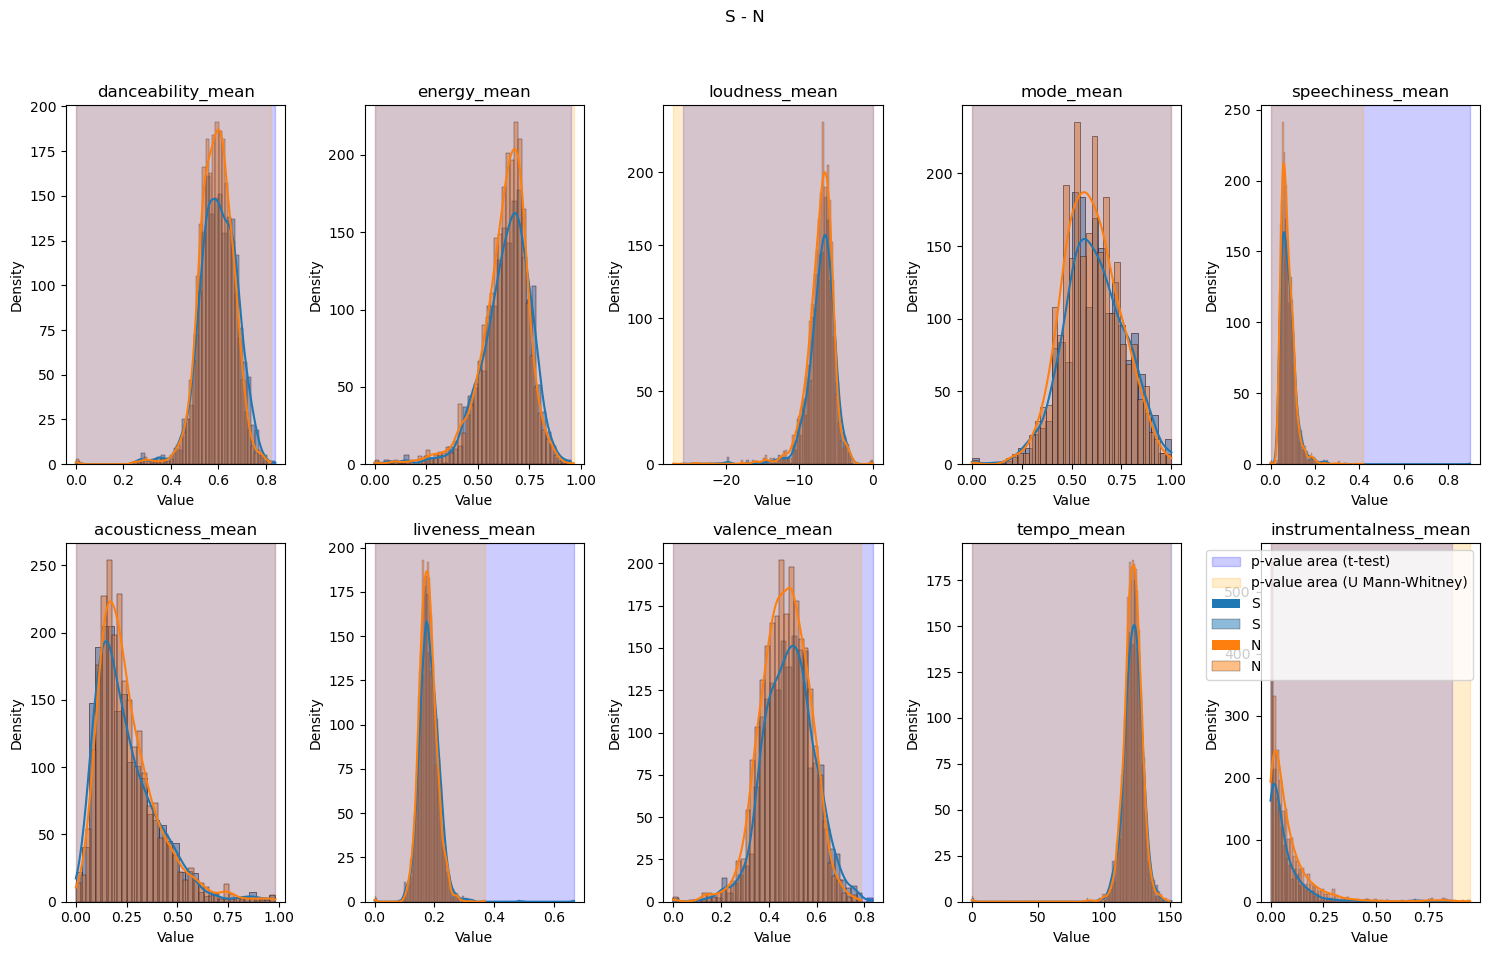

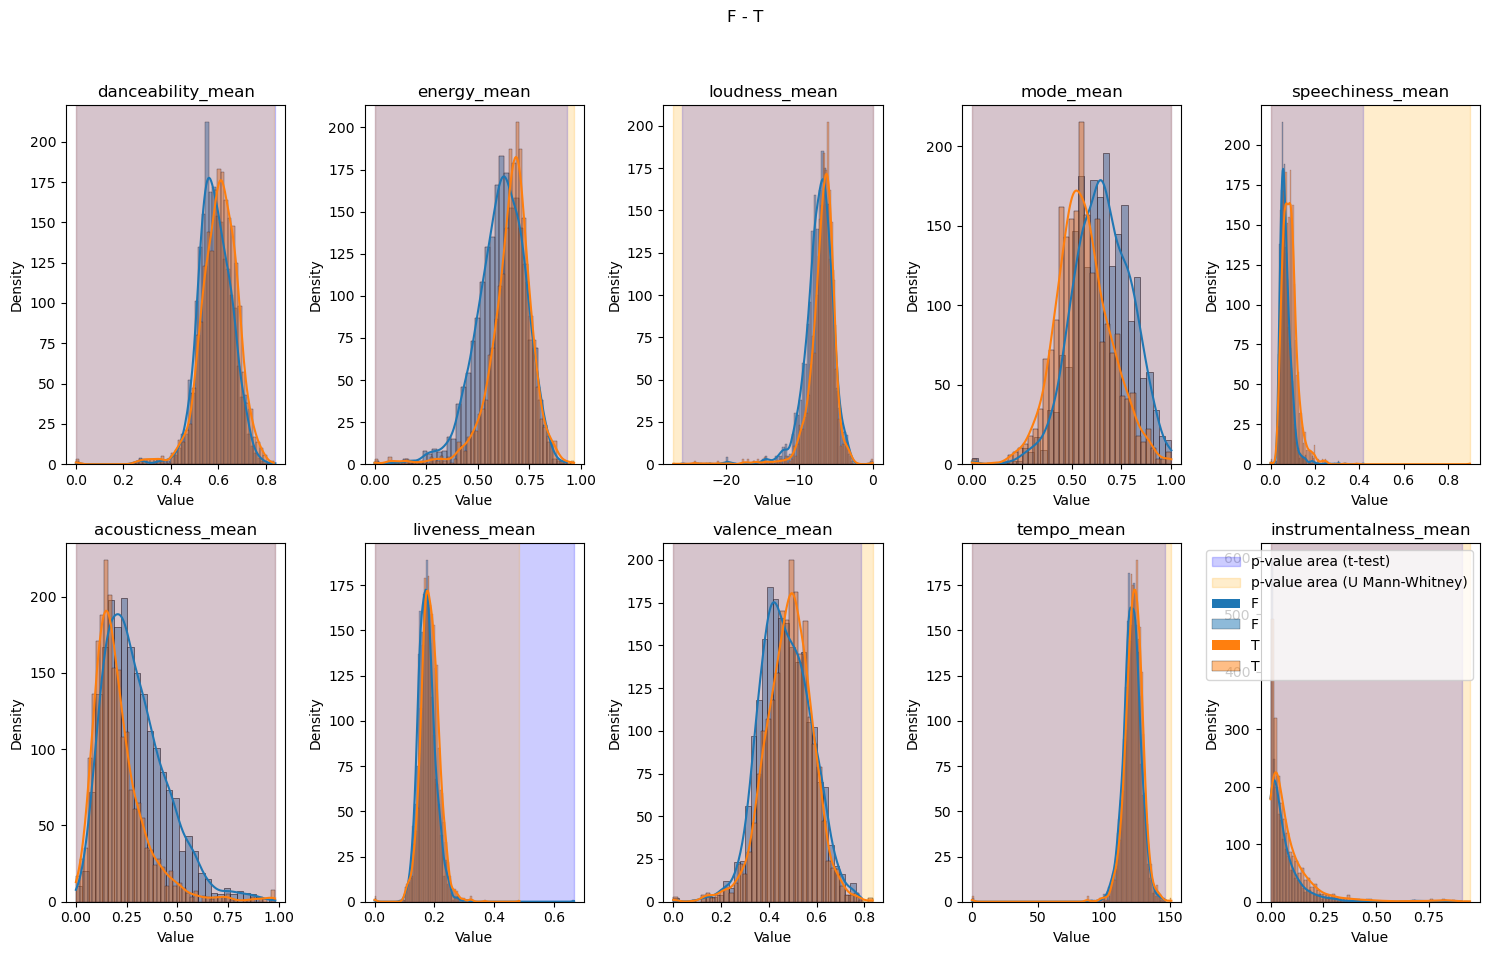

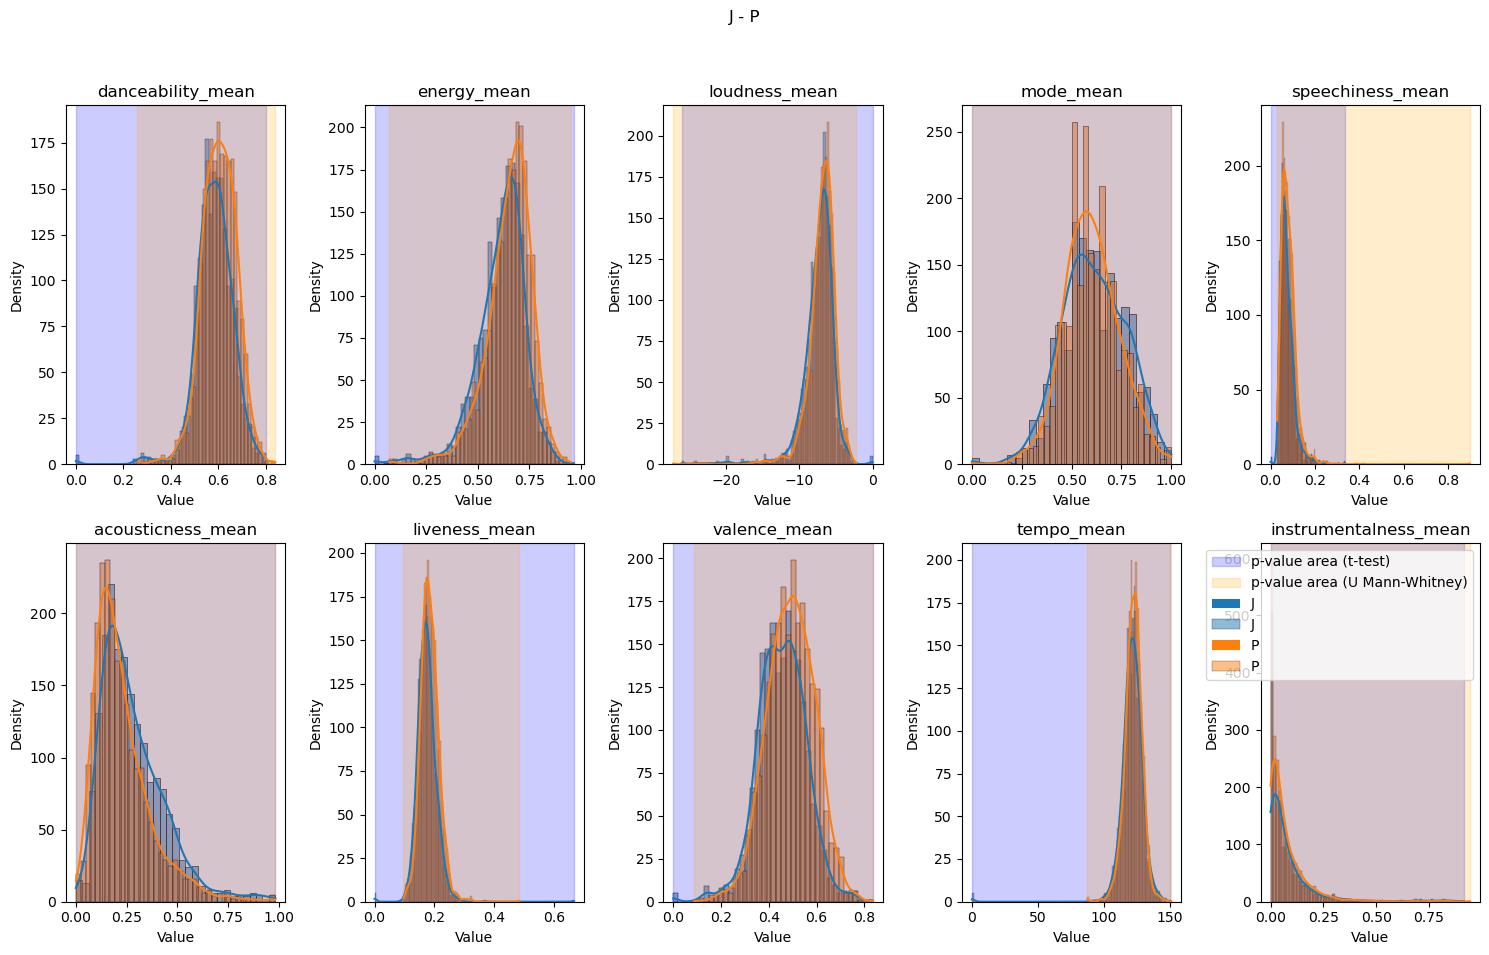

In [83]:
p_vals = {}
for a, b in [["I","E"],["S", "N"],["F", "T"], ["J", "P"]]:
    results_tests = {}
    df1 = types_data[a]
    df2 = types_data[b]
    plt.figure(figsize=(15, 10))
    plt.suptitle(str(a) + str(" - ") + str(b))

    for n in range(len(column_names)):
        if n != 0:
            # Set DataFrames of each audio feature for Mean Distribution p-val testing
            df1_col = df1[column_names[n]]
            df2_col = df2[column_names[n]]
            # Set of subplots for each audio features
            plt.subplot(2, 5, n)
                    
            # Plot histograms 
            sns.histplot(df1_col, kde=True, label= a)
            sns.histplot(df2_col, kde=True, label= b)
                    
            plt.axvspan(np.min(df1_col), np.max(df1_col), color='blue', alpha=0.2, label='p-value area (t-test)')
            plt.axvspan(np.min(df2_col), np.max(df2_col), color='orange', alpha=0.2, label='p-value area (U Mann-Whitney)')
            
            plt.xlabel('Value')
            plt.ylabel('Density')
            plt.title(column_names[n])

            # Perform Shapiro-Wilk test for normality
            _,p_value_df1_col = shapiro(df1_col)
            _,p_value_df2_col = shapiro(df2_col)

            # If both data sets are normally distributed, check homoscedasticity

            if p_value_df1_col > 0.05 and p_value_df2_col > 0.05:
                # Perform Levene test to check for equality of variances (homoscedasticity)
                _, p_value_levene = levene(df1_col, df2_col)

                alpha_levene = 0.05 # Significance level 
                if p_value_levene > alpha_levene:
                    # Perform T-Student
                    t_stat, p_value_ttest = ttest_ind(df1_col, df2_col, equal_var=True)
                    results_tests[column_names[n]] = p_value_ttest

                else:
                    # Perform Welch's t-test 
                    t_stat, p_value_ttest = ttest_ind(df1_col, df2_col, equal_var=False)
                    results_tests[column_names[n]] = p_value_ttest

            
            # If not, perform Mann-Whitney U test       
            else:
                _, p_value = mannwhitneyu(df1_col, df2_col, alternative='two-sided')
                results_tests[column_names[n]] = p_value


            # Convert p-values to formatted floats
            formatted_p_values = {key: '{:.20f}'.format(value) for key, value in results_tests.items()}

            # Create a DataFrame
            df = pd.DataFrame(formatted_p_values.items(), columns=['Feature', 'P-value'])
        p_vals[str(a)] = results_tests
    # Adjust layout for the entire subplot
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.legend(loc="best")

    # Show the plot
    plt.show()

In [84]:
p_val_df = pd.DataFrame(p_vals).T

In [85]:
p_val_df.head()

,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean
I,1.478873e-140,2.101923e-104,1.970471e-116,5.175641e-24,6.994755e-73,7.777958e-102,8.564554e-24,6.598151e-156,3.082827e-20,1.546554e-67
S,7.884545e-06,2.566969e-03,1.422151e-04,8.716995e-05,1.282940e-02,4.525570e-03,5.818106e-06,3.244304e-07,1.642877e-01,2.615613e-13
F,2.286647e-22,5.843753e-51,1.475403e-23,2.904838e-99,2.205898e-95,4.945846e-88,1.008988e-35,9.147771e-09,3.309423e-14,1.319051e-16
J,7.659760e-19,3.695209e-35,1.030500e-17,1.711563e-02,1.065303e-13,4.834905e-34,1.406413e-26,1.242546e-33,1.604760e-04,9.916882e-01


### Describe Method
Storing descriptive statistics of each of the 8 cognitive functions 

In [86]:
extr = pd.DataFrame(types_data["E"])
intr = pd.DataFrame(types_data["I"])
intu = pd.DataFrame(types_data["N"])
sens = pd.DataFrame(types_data["S"])
thin = pd.DataFrame(types_data["T"])
feel = pd.DataFrame(types_data["F"])
judg = pd.DataFrame(types_data["J"])
perc = pd.DataFrame(types_data["P"])

**Below there is a descriptive comparison of each of the four pair of functions**
As statistical support, I reccomend openening the "mbti_p_values.csv" within this repo.
Pd: Apply a  Conditional Formatting Color Scale to table's values to better understand p-values.

**Introversion - Exrtaversion**

In [87]:
# View descriptive statistics
extr.describe()

,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean
count,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000,1984.000000
mean,0.622016,0.669371,-6.585457,0.581674,0.086977,0.205257,0.185601,0.516875,122.765355,0.055763
std,0.076469,0.105635,1.865375,0.146312,0.039611,0.132055,0.034487,0.099486,8.548093,0.107477
min,0.000000,0.000000,-24.341056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.583517,0.626020,-7.177375,0.480000,0.062807,0.121267,0.164644,0.458905,119.077997,0.007126
50%,0.628080,0.685928,-6.269140,0.571429,0.081882,0.171402,0.183114,0.524297,123.127170,0.025065
75%,0.668212,0.729983,-5.613350,0.680000,0.101344,0.248777,0.204246,0.582619,126.998950,0.060021
max,0.840222,0.950320,0.000000,1.000000,0.899660,0.965444,0.667196,0.834400,151.046840,0.944000


In [88]:
# View descriptive statistics
intr.describe()

,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean
count,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000,2217.000000
mean,0.570422,0.603348,-7.645964,0.624860,0.070925,0.292468,0.175995,0.438702,121.088491,0.096694
std,0.068645,0.115985,2.148876,0.147797,0.029070,0.156436,0.028713,0.090848,7.278632,0.123838
min,0.000000,0.000000,-27.224077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.530900,0.540703,-8.425065,0.529412,0.052046,0.176802,0.156640,0.379802,117.142057,0.020415
50%,0.567795,0.613548,-7.371480,0.620000,0.064410,0.261686,0.174006,0.435256,121.265600,0.060261
75%,0.611260,0.678760,-6.525880,0.720000,0.083700,0.379632,0.193267,0.497038,125.414040,0.126934
max,0.793800,0.966200,0.000000,1.000000,0.307100,0.983180,0.320644,0.765475,146.483421,0.904880


In [89]:
# P-Values listed from smallest to largest
p_val_df.iloc[0].sort_values()

valence_mean             6.598151e-156
danceability_mean        1.478873e-140
loudness_mean            1.970471e-116
energy_mean              2.101923e-104
acousticness_mean        7.777958e-102
speechiness_mean          6.994755e-73
instrumentalness_mean     1.546554e-67
mode_mean                 5.175641e-24
liveness_mean             8.564554e-24
tempo_mean                3.082827e-20
Name: I, dtype: float64

In this research, we observed that while tempo exhibited the largest p-value among all the measured audio features (p = 3.082827e-20), it still retained substantial significance in distinguishing between different personality traits. This suggests that there are noteworthy variations in mean audio features linked to the first pair of cognitive functions (Introversion and Extraversion). 
Notably, the analysis hints at valence being a robust predictor (from a musical standpoint) for differentiating Introversion and Extraversion.

**iNtuition - Sensation**

In [90]:
intu.describe()

,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean
count,2415.000000,2415.000000,2415.000000,2415.000000,2415.000000,2415.000000,2415.000000,2415.000000,2415.000000,2415.000000
mean,0.590658,0.630392,-7.222730,0.597030,0.077328,0.254472,0.178548,0.468100,121.771488,0.085051
std,0.073243,0.113775,2.069659,0.143819,0.032915,0.148913,0.029534,0.099940,7.870723,0.123914
min,0.000000,0.000000,-27.224077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.545961,0.574510,-8.038420,0.500000,0.055809,0.151219,0.159736,0.401996,118.030093,0.015345
50%,0.593060,0.648360,-6.890400,0.588235,0.070565,0.217975,0.176966,0.470435,122.068029,0.045078
75%,0.638020,0.704560,-6.025220,0.695048,0.092218,0.321964,0.195785,0.538462,126.047850,0.104658
max,0.820250,0.966200,0.000000,1.000000,0.418614,0.983180,0.368389,0.787346,149.843750,0.944000


In [91]:
sens.describe()

,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean
count,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000,1786.000000
mean,0.600372,0.640122,-7.040178,0.614518,0.080099,0.246967,0.183214,0.485791,122.027718,0.066969
std,0.081229,0.118715,2.108519,0.154420,0.038389,0.155544,0.034738,0.105538,8.048573,0.109090
min,0.000000,0.000000,-25.873324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.550890,0.576072,-7.865000,0.514445,0.056149,0.134775,0.161996,0.413985,117.956515,0.007357
50%,0.602090,0.656100,-6.761826,0.600000,0.073449,0.207786,0.180109,0.486750,122.428790,0.033039
75%,0.656389,0.720734,-5.842435,0.720000,0.095358,0.327490,0.202786,0.553850,126.563970,0.081558
max,0.840222,0.950320,0.000000,1.000000,0.899660,0.981540,0.667196,0.834400,151.046840,0.858928


In [92]:
p_val_df.iloc[1].sort_values()

instrumentalness_mean    2.615613e-13
valence_mean             3.244304e-07
liveness_mean            5.818106e-06
danceability_mean        7.884545e-06
mode_mean                8.716995e-05
loudness_mean            1.422151e-04
energy_mean              2.566969e-03
acousticness_mean        4.525570e-03
speechiness_mean         1.282940e-02
tempo_mean               1.642877e-01
Name: S, dtype: float64

Analyzing the second pair, we uncover substantial dissimilarities across the various audio features, with the exception of tempo (p = 0.1642 > 0.05). Consequently, th analysis cautions against considering tempo as a dependable parameter in predicting an individual's second cognitive function.I would suggest not consider tempo as a viable predictor when it comes to forecasting a subject's MBTI personality type.

Considering basic theory from MBTI and Carl Jung, it becomes evident that intuition assumes a vital role in the realm of abstraction. This conceptual alignment elucidates the observed association od higher instrumentalness to iNtuitive types related . The capacity of instrumentalness to create an immersive experience devoid of explicit linguistic guidance (lyrics) harmonizes with the cognitive inclinations of these personality types.

**Thinking - Feeling**

In [93]:
thin.describe()

,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean
count,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000,2136.000000
mean,0.604009,0.657918,-6.928081,0.558765,0.087583,0.210969,0.185756,0.482873,122.544594,0.088389
std,0.079492,0.108886,2.097181,0.138600,0.038748,0.136015,0.031915,0.099141,8.142993,0.127439
min,0.000000,0.000000,-27.224077,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.558306,0.612568,-7.546029,0.470588,0.063498,0.125566,0.166192,0.423359,118.701274,0.016104
50%,0.608258,0.672272,-6.609120,0.545455,0.083449,0.177075,0.184148,0.488637,122.932780,0.047093
75%,0.655852,0.720400,-5.860785,0.640000,0.102968,0.257137,0.204448,0.548425,126.996551,0.109685
max,0.833435,0.966200,0.000000,1.000000,0.899660,0.981540,0.484588,0.834400,151.046840,0.944000


In [94]:
feel.describe()

,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean
count,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000,2065.000000
mean,0.585250,0.610335,-7.369622,0.651736,0.069118,0.292979,0.175128,0.468120,121.193412,0.065960
std,0.072884,0.118149,2.054916,0.143868,0.028617,0.155978,0.031042,0.105795,7.680540,0.106573
min,0.000000,0.000000,-26.074700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.539409,0.541254,-8.274720,0.560000,0.051579,0.174988,0.154864,0.394970,117.406806,0.008236
50%,0.582543,0.620826,-7.126960,0.650000,0.063432,0.262057,0.172960,0.461958,121.330800,0.033063
75%,0.633810,0.693050,-6.139840,0.760000,0.079750,0.380699,0.191546,0.542420,125.544941,0.080715
max,0.840222,0.930500,0.000000,1.000000,0.418614,0.983180,0.667196,0.787346,146.568600,0.904880


In [95]:
p_val_df.iloc[2].sort_values()

mode_mean                2.904838e-99
speechiness_mean         2.205898e-95
acousticness_mean        4.945846e-88
energy_mean              5.843753e-51
liveness_mean            1.008988e-35
loudness_mean            1.475403e-23
danceability_mean        2.286647e-22
instrumentalness_mean    1.319051e-16
tempo_mean               3.309423e-14
valence_mean             9.147771e-09
Name: F, dtype: float64

In the context of MBTI's third cognitive function pair, a pronounced statistical significance is observed across all audio features. As the most discriminant audio feature, the variable "mode" exhibits the most substantial difference, indicating a prevalent use of the major scale in the tracks associated with individuals exhibiting feeler traits.

**Perceiving - Judging**

In [96]:
judg.describe()

,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean
count,1870.000000,1870.000000,1870.000000,1870.000000,1870.000000,1870.000000,1870.000000,1870.000000,1870.000000,1870.000000
mean,0.583061,0.611486,-7.422733,0.610299,0.074870,0.279800,0.175115,0.454310,121.345531,0.081126
std,0.080724,0.120347,2.291199,0.160688,0.032031,0.158504,0.032762,0.101917,9.371966,0.128864
min,0.000000,0.000000,-26.074700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.538263,0.552303,-8.250495,0.500000,0.053727,0.165761,0.154882,0.388435,117.453160,0.012079
50%,0.584901,0.630720,-7.022838,0.600000,0.068219,0.244055,0.173120,0.455829,121.795690,0.040750
75%,0.631640,0.689004,-6.158703,0.727273,0.089069,0.363620,0.192198,0.522304,126.191577,0.094442
max,0.802140,0.966200,0.000000,1.000000,0.335722,0.983180,0.667196,0.834400,149.843750,0.916833


In [97]:
perc.describe()

,danceability_mean,energy_mean,loudness_mean,mode_mean,speechiness_mean,acousticness_mean,liveness_mean,valence_mean,tempo_mean,instrumentalness_mean
count,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000,2331.000000
mean,0.604196,0.653014,-6.922410,0.599784,0.081423,0.228402,0.184877,0.492718,122.309526,0.074346
std,0.072308,0.108923,1.880459,0.138099,0.037587,0.142144,0.030567,0.100151,6.555032,0.108759
min,0.258889,0.071149,-27.224077,0.000000,0.029853,0.000798,0.096667,0.088394,87.263889,0.000000
25%,0.556500,0.595921,-7.719758,0.500000,0.057864,0.129106,0.164639,0.426224,118.452802,0.012045
50%,0.605380,0.668176,-6.674120,0.600000,0.075039,0.192911,0.182544,0.495393,122.535820,0.039753
75%,0.655067,0.724240,-5.819836,0.684211,0.097021,0.290326,0.202688,0.561464,126.304790,0.096034
max,0.840222,0.950320,-2.246214,1.000000,0.899660,0.981540,0.484588,0.834000,151.046840,0.944000


In [98]:
p_val_df.iloc[3].sort_values()

energy_mean              3.695209e-35
acousticness_mean        4.834905e-34
valence_mean             1.242546e-33
liveness_mean            1.406413e-26
danceability_mean        7.659760e-19
loudness_mean            1.030500e-17
speechiness_mean         1.065303e-13
tempo_mean               1.604760e-04
mode_mean                1.711563e-02
instrumentalness_mean    9.916882e-01
Name: J, dtype: float64

In terms of theoretical explanation, this is where I lack compelling arguments the most. Nevertheless, an interesting perspective emerges when interpreting the energy (audio feature with the smallest p-value in the fourth and last pair of functions) as a manifestation of a track's entropy or chaos. This viewpoint aims to grasp some theory on J's being more rigid, ordered, and "put-together" since lower energy (aka track's chaos) is associated with xxxJ types. Spotify describes the perceptual factors influencing this feature as dynamic range, perceived loudness, timbre, onset rate, and overall entropy.

## Extra
Below there's commented code to download the .csv of each of the 8 pair of cognitive functions as well as the one containg the p-values.

In [99]:
# P-Values Table
#p_val_df.to_csv("p_values_mbti_spotify.csv") 

# Cognitive Functions Tables (uncomment the below code and run it to download the .csv files)
#extr.to_csv("extroversion.csv")
#intr.to_csv("introversion.csv")
#intu_to_csv("intuition.csv")
#sens.to_csv("sensation.csv")
#thin.to_csv("thinking.csv")
#feel.to_csv("feeling.csv")
#judg.to_csv("judging.csv")
#perc.to_csv("perceiving.csv")
